In [1]:
import pandas as pd
import janitor
import gc
from utilities.utils import get_fulldata
from utilities.graph_utils import conbarplot
from utilities.graph_utils import save_mpl_fig
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

FP_GENDER = '../data/hindi_eng_names_gender.csv.gz'

usecols = ['account_no', 'name_of_ryot', '6', '7', '8']
df = (get_fulldata(**{'usecols':usecols})
      # Compute land area (in acres)
      .assign(tt_area_acre=lambda df: df['6']+df['7']/100+df['8']*2.4711)
      .remove_columns(['6', '7', '8'])
      # Get religion via hindi names
      .merge((pd.read_csv(FP_GENDER, usecols=['name', 'pred_gender'])
              .rename_column('name', 'name_of_ryot')
              .rename_column('pred_gender', 'gender')
             ), how='left', on='name_of_ryot', validate='m:1'
            )
      .dropna(subset='gender')
     )
df.shape

(40068882, 4)

In [2]:
df.head(3)

,name_of_ryot,account_no,tt_area_acre,gender
0,मुसमात देवकी ओझा,701010001000008,8.525,female
1,म.तजमुल हुसैन,701010001000003,0.560,male
2,म.तजमुल हुसैन,701010001000003,0.000,male


In [3]:
nplots_by_account = (df
                     .groupby(['account_no', 'gender']).size().reset_index()
                     .rename_column(0, 'nplots')
                    )
print(f'{len(nplots_by_account)=:,}')
print(nplots_by_account.head(3))

len(nplots_by_account)=11,488,571
        account_no  gender  nplots
0  101010273000001  female       2
1  101010273000002    male       8
2  101010273000003    male       1


In [4]:
landarea_by_account = (df
                       .groupby(['account_no', 'gender'])
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

len(landarea_by_account)=11,405,146
        account_no  gender  tt_area_acre
0  101010273000001  female         0.585
1  101010273000002    male         1.545
2  101010273000003    male         0.080


### Aggregate numbers

In [5]:
tt_bihar_pop = 104_099_452  # https://www.census2011.co.in/census/state/bihar.html
# 100*49_821_295/104_099_452
pct_bihar_female = .4785932494630231 

In [6]:
# Percentage of Biharis owning plots
n_acct_holders = df.account_no.nunique()
pct_plot_owned_biharis = 100 * (n_acct_holders/tt_bihar_pop)
print(f"Percentage of Biharis owning plots: {pct_plot_owned_biharis:.1f}%")

Percentage of Biharis owning plots: 11.0%


In [7]:
# Percentage of female owning plots
n_female_owning_plot = df.query('gender=="female"').account_no.nunique()
n_female = pct_bihar_female * tt_bihar_pop 
pct_female_owning_land = 100 * (n_female_owning_plot/n_female)
print(f"Percentage of females owning plots: {pct_female_owning_land:.1f}%")

Percentage of females owning plots: 6.0%


In [8]:
print(f"{n_female_owning_plot=:,}")

n_female_owning_plot=2,982,312


In [9]:
# Percentage of male owning plots
n_male_owning_plot = df.query('gender=="male"').account_no.nunique()
n_male = (1-pct_bihar_female) * tt_bihar_pop 
pct_male_owning_land = 100 * (n_male_owning_plot/n_male)
print(f"Percentage of males owning plots: {pct_male_owning_land:.1f}%")

Percentage of males owning plots: 15.7%


In [10]:
print(f"{n_male_owning_plot=:,}")

n_male_owning_plot=8,506,259


In [11]:
# Percentage of plots owned by females
plots_owned_by_females = nplots_by_account.query('gender=="female"')['nplots'].sum()
tt_plots = nplots_by_account.nplots.sum()
pct_plot_owned_by_females = 100*(plots_owned_by_females/tt_plots)
print(f"Percentage of plots owned by females: {pct_plot_owned_by_females:.1f}%")

Percentage of plots owned by females: 22.4%


### Number of plots

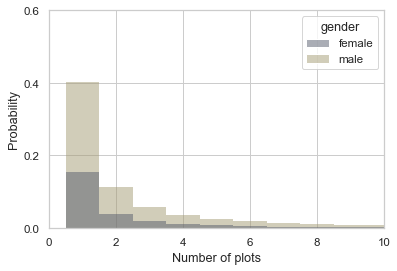

In [12]:
# Truncated > 90th percentile
sns.histplot(data=nplots_by_account, x="nplots", 
             hue='gender',
             discrete=True,
             stat="probability", 
             palette='cividis'
            )
plt.xlabel('Number of plots')
plt.yticks([0,.2,.4,.6])
plt.xlim(0, 10)
save_mpl_fig('../figures/gender_number_plots')

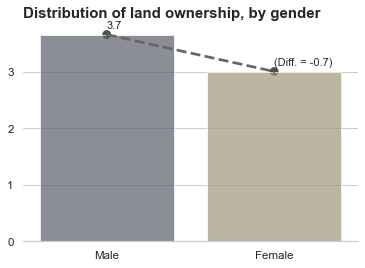

In [13]:
conbarplot(x='gender', y='nplots', data=nplots_by_account, 
           grouplab='gender', groups=['male', 'female'],
           annote_scaler=.1,
           xticklabels=['Male', 'Female'],
           title='Distribution of land ownership, by gender'
          )    
save_mpl_fig('../figures/gender_barplot_plots')

### Land area

In [15]:
landarea_by_account = (df
                       .groupby(['account_no', 'gender'])
                       .sum().reset_index()
                       .query('tt_area_acre>0')
                      )
del df
gc.collect()
print(f'{len(landarea_by_account)=:,}')
print(landarea_by_account.head(3))

len(landarea_by_account)=11,405,146
        account_no  gender  tt_area_acre
0  101010273000001  female         0.585
1  101010273000002    male         1.545
2  101010273000003    male         0.080


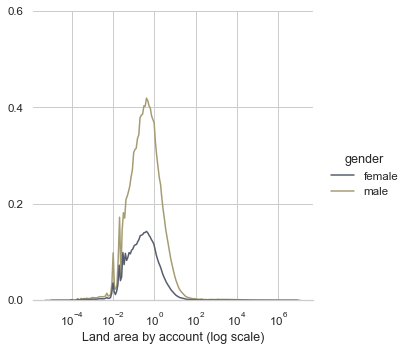

In [16]:
sns.displot(data=landarea_by_account,
            x='tt_area_acre',
            kind='kde',
            hue='gender',
            log_scale=True,
            palette='cividis',
            cut=0
            )
plt.ylabel('')
plt.xlabel('Land area by account (log scale)')
plt.yticks([0,.2,.4,.6])
sns.despine(left=True)
save_mpl_fig('../figures/gender_plot_area')

<AxesSubplot:title={'left':'Distribution of land area owned, by gender'}>

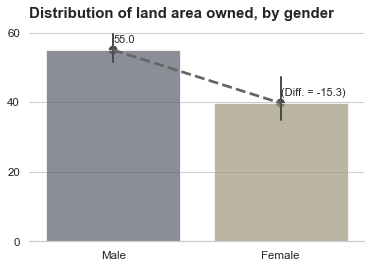

In [18]:
conbarplot(x='gender', y='tt_area_acre', data=landarea_by_account, 
           grouplab='gender', groups=['male', 'female'],
           xticklabels=['Male', 'Female'],
           title='Distribution of land area owned, by gender'
          )    
save_mpl_fig('../figures/gender_barplot_plotarea')